# LSTM 

### Importing the module that scrapes the internet for the latest values count

In [206]:
import csv_updater

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

#### Getting the starter data from John Hopkin's CSV File

In [208]:
df = pd.read_csv("johnhopkins-3March.csv")

In [209]:
df = df.T

In [210]:
cols_drop = []
for i in range(114):
    if i != 0 and i != 5:
        cols_drop.append(i)
df.drop(df.columns[cols_drop], axis = 1, inplace = True) 

In [211]:
df

,0,5
Province/States,Confirmed,Deaths
Country/Region,Globally,Mainland China
WHO region,NaN,Western Pacific Region
1/21/2020,282,NaN
1/22/2020,314,NaN
1/23/2020,581,NaN
1/24/2020,846,NaN
1/25/2020,1320,NaN
1/26/2020,2014,NaN
1/27/2020,2798,80


In [212]:
df.drop(['Country/Region', 'WHO region', 'Province/States'], inplace = True)

#### Cleaning the Data

In [213]:
df.head()

,0,5
1/21/2020,282,NaN
1/22/2020,314,NaN
1/23/2020,581,NaN
1/24/2020,846,NaN
1/25/2020,1320,NaN


In [214]:
df.shape

(43, 2)

In [215]:
df.rename(columns = {0:'Infected', 5:'Deaths'}, inplace = True)

In [216]:
df.head()

,Infected,Deaths
1/21/2020,282,NaN
1/22/2020,314,NaN
1/23/2020,581,NaN
1/24/2020,846,NaN
1/25/2020,1320,NaN


In [217]:
df.shape

(43, 2)

#### Using the dates as indices

In [218]:
dates_unix = []
start = 1579478400
for i in range(43):
    start += 86400
    dates_unix.append(start)

print(dates_unix)

[1579564800, 1579651200, 1579737600, 1579824000, 1579910400, 1579996800, 1580083200, 1580169600, 1580256000, 1580342400, 1580428800, 1580515200, 1580601600, 1580688000, 1580774400, 1580860800, 1580947200, 1581033600, 1581120000, 1581206400, 1581292800, 1581379200, 1581465600, 1581552000, 1581638400, 1581724800, 1581811200, 1581897600, 1581984000, 1582070400, 1582156800, 1582243200, 1582329600, 1582416000, 1582502400, 1582588800, 1582675200, 1582761600, 1582848000, 1582934400, 1583020800, 1583107200, 1583193600]


In [219]:
df['Date'] = dates_unix

In [220]:
df.head()

,Infected,Deaths,Date
1/21/2020,282,NaN,1579564800
1/22/2020,314,NaN,1579651200
1/23/2020,581,NaN,1579737600
1/24/2020,846,NaN,1579824000
1/25/2020,1320,NaN,1579910400


In [221]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')

In [222]:
df.head()

,Infected,Deaths,Date
1/21/2020,282,NaN,2020-01-21
1/22/2020,314,NaN,2020-01-22
1/23/2020,581,NaN,2020-01-23
1/24/2020,846,NaN,2020-01-24
1/25/2020,1320,NaN,2020-01-25


In [223]:
df.set_index = df['Date']

In [225]:
start

1583193600

In [226]:
df.head()

,Infected,Deaths,Date
1/21/2020,282,NaN,2020-01-21
1/22/2020,314,NaN,2020-01-22
1/23/2020,581,NaN,2020-01-23
1/24/2020,846,NaN,2020-01-24
1/25/2020,1320,NaN,2020-01-25


In [227]:
df = df.reset_index(drop=True)

In [229]:
df.set_index("Date", inplace = True) 

In [230]:
df.head()

,Infected,Deaths
Date,,
2020-01-21,282,NaN
2020-01-22,314,NaN
2020-01-23,581,NaN
2020-01-24,846,NaN
2020-01-25,1320,NaN


In [231]:
df.fillna(0, inplace=True)

In [232]:
df.head()

,Infected,Deaths
Date,,
2020-01-21,282.0,0.0
2020-01-22,314.0,0.0
2020-01-23,581.0,0.0
2020-01-24,846.0,0.0
2020-01-25,1320.0,0.0


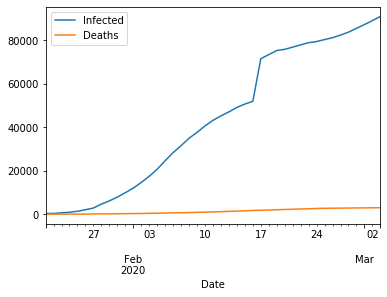

In [233]:
df.plot()

In [234]:
infected, deaths = csv_updater.get_nums()

In [272]:
import datetime
now = datetime.datetime.now()

In [273]:
currdate = now.strftime("%Y-%m-%d")

In [274]:
infected, deaths

(98752, 3389)

In [278]:
currdate = '2020-03-06'
date_object = datetime.datetime.strptime(currdate, '%Y-%m-%d').date()
type(date_object)

datetime.date

In [277]:
df.loc[currdate].Infected = infected
df.loc[currdate].Deaths = deaths

KeyError: '2020-03-06'

In [263]:
df

,Infected,Deaths
Date,,
2020-01-21,282.0,0.0
2020-01-22,314.0,0.0
2020-01-23,581.0,0.0
2020-01-24,846.0,0.0
2020-01-25,1320.0,0.0
2020-01-26,2014.0,0.0
2020-01-27,2798.0,80.0
2020-01-28,4593.0,106.0
2020-01-29,6065.0,132.0
